In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@38f8e53d
import spark.implicits._

In [2]:
val filePathMercados = "../../data/parquet/dsMercadoNacionalTotalPrueba.parquet"

val dfMercados: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .parquet(filePathMercados)

val filePathBalance = "../../data/parquet/dsBalanceNacional11-24.parquet"         
val dfBalance: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .parquet(filePathBalance)


parquet at cmd1.sc:7

1 / 1

parquet at cmd1.sc:14

1 / 1

filePathMercados: String = "../../data/parquet/dsMercadoNacionalTotalPrueba.parquet"
dfMercados: DataFrame = [Fecha: timestamp, Valor_Mercado_Spot: double ... 3 more fields]
filePathBalance: String = "../../data/parquet/dsBalanceNacional11-24.parquet"
dfBalance: DataFrame = [Familia: string, Tipo: string ... 5 more fields]

In [3]:
import org.apache.spark.sql.functions._

val datosMensualesMercadosBalance = {
  val datosBalanceMensual = dfBalance
    .filter($"Tipo".isin("Generación renovable", "Generación no renovable", "Saldo I. internacionales"))
    .withColumn("Mes", date_format(col("FechaCompleta"), "yyyy-MM")) // Extraer año y mes como "yyyy-MM"
    .groupBy("Mes")
    .pivot($"Tipo")
    .agg(sum("Valor").as("MWh"))
    .orderBy("Mes")

  val datosMercadosMensual = dfMercados
    .withColumn("Mes", date_format(col("Fecha"), "yyyy-MM")) // Extraer año y mes como "yyyy-MM"
    .groupBy("Mes")
    .agg(avg("Valor_Mercado_Spot").as("PrecioPromedioMensual"))
    .orderBy("Mes")

  datosMercadosMensual.join(datosBalanceMensual, Seq("Mes"), "left")
}



pivot at cmd2.sc:8

15 / 15

pivot at cmd2.sc:8

200 / 200

pivot at cmd2.sc:8

1 / 1

import org.apache.spark.sql.functions._


datosMensualesMercadosBalance: DataFrame = [Mes: string, PrecioPromedioMensual: double ... 3 more fields]

In [4]:
// Recoger los datos con un collect
val datosParaGrafico = datosMensualesMercadosBalance.collect()

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

168 / 168

collect at cmd3.sc:1

15 / 15

collect at cmd3.sc:1

200 / 200

collect at cmd3.sc:1

200 / 200

collect at cmd3.sc:1

132 / 132

datosParaGrafico: Array[Row] = Array(
  [2013-12,20.02,1.5366845417499999E7,8455898.010499999,-413695.157],
  [2014-01,33.62260752688169,1.23053367865E7,1.1842675513499998E7,39079.202999999994],
  [2014-02,17.08921130952381,9999119.282000003,1.2515829091000002E7,-488067.18600000005],
  [2014-03,26.69189516129032,1.09664441905E7,1.1852725894499999E7,-243092.135],
  [2014-04,26.47263888888891,1.0517044867999997E7,1.0316309912000002E7,-616989.6029999999],
  [2014-05,42.40516129032255,1.22648578905E7,9061676.8965,-273634.7259999999],
  [2014-06,50.97758333333327,1.3773314026999999E7,7779169.039999999,-287146.80500000005],
  [2014-07,48.23134408602148,1.5034826443499997E7,8143710.001499998,-479648.7020000001],
  [2014-08,49.88380376344092,1.49721713535E7,7090929.7715,-248766.64100000003],
  [2014-09,58.903583333333266,1.6687641214999996E7,5390456.336,-333969.006],
  [2014-10,55.138602150537636,1.5217319072499998E7,6265688.350499999,-283116.8050000001],
  [2014-11,46.756819444444346,1.270974

In [7]:
// Extraer las secuencias individuales de los datos
val fechas = datosParaGrafico.map(row => row.getAs[String]("Mes")).toSeq
val preciosDiarios = datosParaGrafico.map(row => row.getAs[Double]("PrecioPromedioMensual")).toSeq
val generacionNoRenovable = datosParaGrafico.map(row => row.getAs[Double]("Generación no renovable")).toSeq
val generacionRenovable = datosParaGrafico.map(row => row.getAs[Double]("Generación renovable")).toSeq
val saldo = datosParaGrafico.map(row => row.getAs[Double]("Saldo I. internacionales")).toSeq 

fechas: Seq[String] = WrappedArray(
  "2013-12",
  "2014-01",
  "2014-02",
  "2014-03",
  "2014-04",
  "2014-05",
  "2014-06",
  "2014-07",
  "2014-08",
  "2014-09",
  "2014-10",
  "2014-11",
  "2014-12",
  "2015-01",
  "2015-02",
  "2015-03",
  "2015-04",
  "2015-05",
  "2015-06",
  "2015-07",
  "2015-08",
  "2015-09",
  "2015-10",
  "2015-11",
  "2015-12",
  "2016-01",
  "2016-02",
  "2016-03",
  "2016-04",
  "2016-05",
  "2016-06",
  "2016-07",
  "2016-08",
  "2016-09",
  "2016-10",
  "2016-11",
  "2016-12",
  "2017-01",
...
preciosDiarios: Seq[Double] = WrappedArray(
  20.02,
  33.62260752688169,
  17.08921130952381,
  26.69189516129032,
  26.47263888888891,
  42.40516129032255,
  50.97758333333327,
  48.23134408602148,
  49.88380376344092,
  58.903583333333266,
  55.138602150537636,
  46.756819444444346,
  47.5039112903225,
  51.54303763440853,
  42.60608630952376,
  43.08432795698914,
  45.38505555555549,
  45.14830645161278,
  54.745541666666576,
  59.52674731182782,
  55.609583

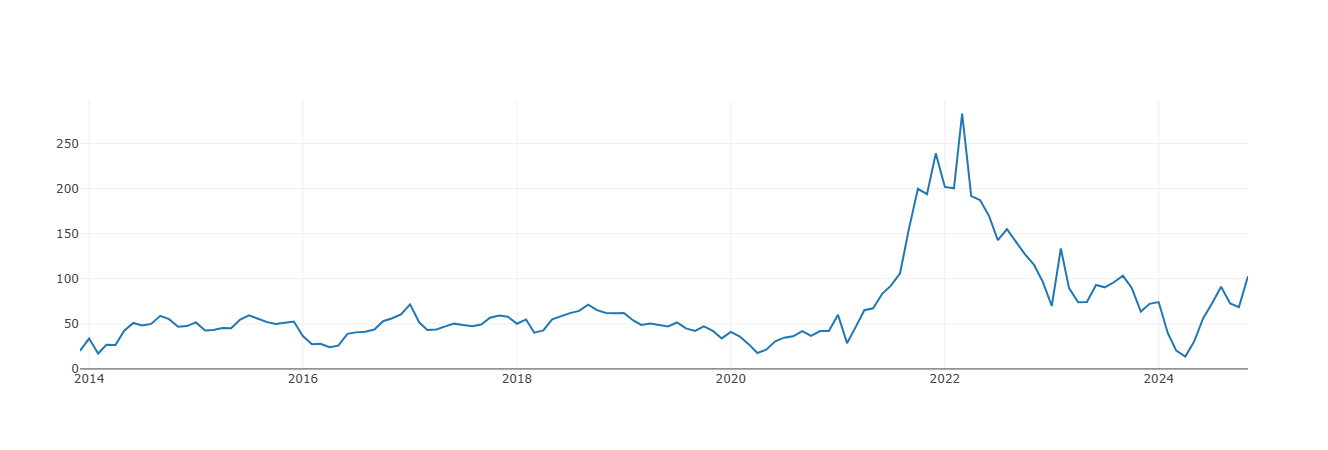

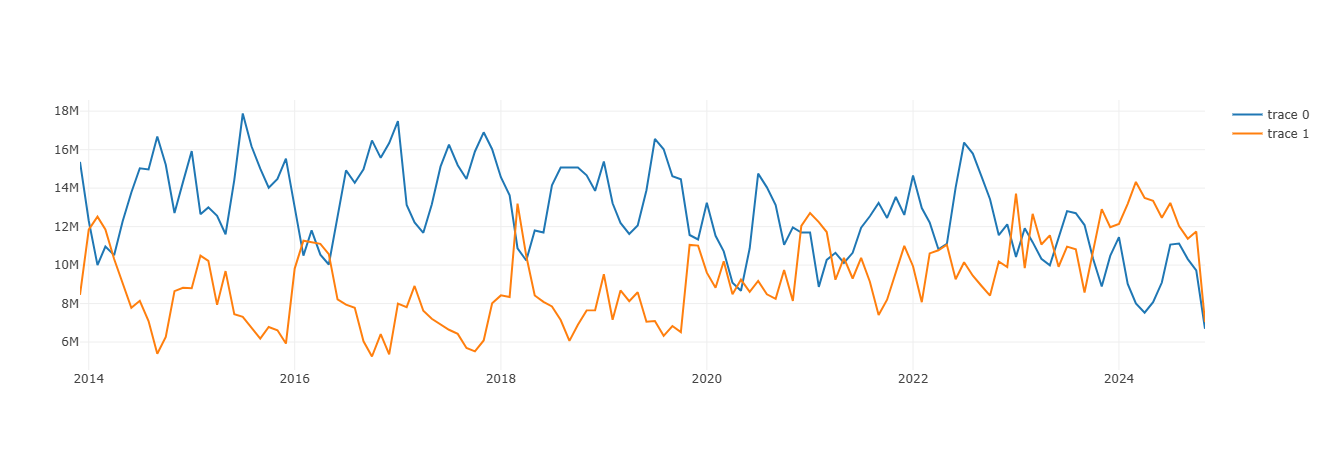

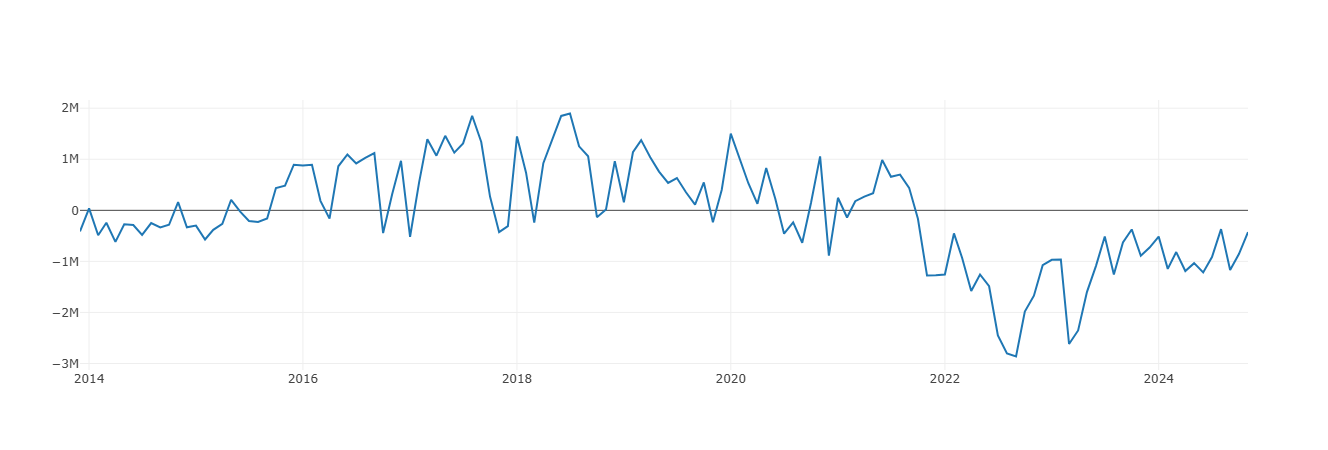

tracePrecios: Scatter = Scatter(
  Some(
    Strings(
      WrappedArray(
        "2013-12",
        "2014-01",
        "2014-02",
        "2014-03",
        "2014-04",
        "2014-05",
        "2014-06",
        "2014-07",
        "2014-08",
        "2014-09",
        "2014-10",
        "2014-11",
        "2014-12",
        "2015-01",
        "2015-02",
        "2015-03",
        "2015-04",
        "2015-05",
        "2015-06",
        "2015-07",
        "2015-08",
        "2015-09",
        "2015-10",
        "2015-11",
        "2015-12",
        "2016-01",
        "2016-02",
        "2016-03",
        "2016-04",
        "2016-05",
        "2016-06",
        "2016-07",
        "2016-08",
        "2016-09",
        "2016-10",
...
traceNoRenovable: Scatter = Scatter(
  Some(
    Strings(
      WrappedArray(
        "2013-12",
        "2014-01",
        "2014-02",
        "2014-03",
        "2014-04",
        "2014-05",
        "2014-06",
        "2014-07",
        "2014-08",
        

In [8]:
val tracePrecios = Scatter(
  fechas,
  preciosDiarios
)

val traceNoRenovable = Scatter(
  fechas,
  generacionNoRenovable
)

val traceRenovable = Scatter(
  fechas,
  generacionRenovable
)

val traceSaldo = Scatter(
  fechas, 
  saldo
)
val dataPrecios = Seq(tracePrecios)
val dataRenovableNoRenovable = Seq(traceNoRenovable,traceRenovable)
val dataSaldo = Seq(traceSaldo)
// Dibujar el gráfico de líneas
plot(dataPrecios)
plot(dataRenovableNoRenovable)
plot(dataSaldo)


In [3]:
dfMercados.show()

show at cmd2.sc:1

1 / 1

+-------------------+------------------+-----------------------+----------+------------------+
|              Fecha|Valor_Mercado_Spot|Porcentaje_Mercado_Spot|PVPC_Valor|   PVPC_Porcentaje|
+-------------------+------------------+-----------------------+----------+------------------+
|2024-01-29 03:00:00|             51.58|     0.3360917443148498|    101.89|0.6639082556851502|
|2024-01-01 18:00:00|             54.97|     0.3472301181226707|    103.34|0.6527698818773293|
|2024-01-09 01:00:00|             98.43|     0.4176602876904146|    137.24|0.5823397123095855|
|2024-01-15 14:00:00|              90.1|    0.36747012520902156|    155.09|0.6325298747909784|
|2024-01-26 21:00:00|             74.98|    0.34756408473554906|    140.75|0.6524359152644509|
|2024-01-10 11:00:00|             99.99|     0.3258383028644051|    206.88|0.6741616971355948|
|2024-01-19 11:00:00|             78.74|     0.2898582735137125|    192.91|0.7101417264862876|
|2024-01-05 23:00:00|              52.5|    0.3400

In [3]:
val mercadoDiario = dfMercados
    .groupBy(date_format(col("Fecha"),"yyyy-MM-dd").as("FechaDia"))
    .agg(avg("Valor_Mercado_Spot").as("ValorMercadoSpot"))
    .withColumn("Precio mercado spot €", round(col("ValorMercadoSpot"), 2))
    .drop("ValorMercadoSpot")
    .orderBy(desc("FechaDia"))
mercadoDiario.orderBy("FechaDia").show()

show at cmd2.sc:7

15 / 15

show at cmd2.sc:7

200 / 200

+----------+------------------+
|  FechaDia|Valor marcado spot|
+----------+------------------+
|2013-12-31|             20.02|
|2014-01-01|              5.19|
|2014-01-02|              25.7|
|2014-01-03|             40.18|
|2014-01-04|               4.3|
|2014-01-05|              4.93|
|2014-01-06|             13.58|
|2014-01-07|             48.33|
|2014-01-08|             40.83|
|2014-01-09|             49.79|
|2014-01-10|             56.65|
|2014-01-11|              49.9|
|2014-01-12|             37.28|
|2014-01-13|             37.57|
|2014-01-14|             34.91|
|2014-01-15|              49.2|
|2014-01-16|             41.73|
|2014-01-17|             41.78|
|2014-01-18|             43.69|
|2014-01-19|             32.73|
+----------+------------------+
only showing top 20 rows



mercadoDiario: Dataset[Row] = [FechaDia: string, Valor marcado spot: double]

In [ ]:
//CALCULAR EL PORCENTAJE SOBRE EL TOTAL DE CADA TIPO DE ENERGIA

import org.apache.spark.sql.expressions.Window
import org.apache.spark.sql.functions._

// Filtrar los datos para excluir ciertos valores
val dfBalanceFiltrado = dfBalance
  .filter($"Compuesto" === false)
  .filter($"Familia" =!= "Demanda")
  .withColumn("FechaDia", date_format(col("FechaCompleta"), "yyyy-MM-dd")) // Extraer solo la parte del día

// Calcular el porcentaje de cada tipo de energía respecto al total diario
val windowTotal = Window.partitionBy("FechaDia")

val dfBalanceConPorcentajeTotal = dfBalanceFiltrado
  .withColumn("GeneracionTotalDiaria", sum("Valor").over(windowTotal)) // Total de generación por cada día
  .withColumn("PorcentajeRespectoTotal", round((col("Valor") / col("GeneracionTotalDiaria")) * 100, 2))
  .select("Familia", "Tipo", "FechaCompleta", "FechaDia", "Valor", "PorcentajeRespectoTotal")

In [ ]:


// Calcular el ranking por porcentaje
val windowRanking = Window.partitionBy("FechaDia").orderBy(desc("PorcentajeRespectoTotal"))

val dfRankeado = dfBalanceConPorcentajeTotal
  .withColumn("rank", row_number().over(windowRanking))
  .filter($"rank" <= 3) // Filtrar solo los primeros 3 valores
  .orderBy("FechaCompleta", "rank")

// Pivotar para generar columnas separadas por rank
val dfPivotadoTipo = dfRankeado
    .groupBy("FechaCompleta")
    .pivot("rank")
    .agg(first("Tipo").as("Tipo"))

val dfPivotadoPorcentaje = dfRankeado
    .groupBy("FechaCompleta")
    .pivot("rank")
    .agg(first("PorcentajeRespectoTotal").as("Porcentaje"))

val dfFinal = dfPivotadoTipo
    .join(dfPivotadoPorcentaje, "FechaCompleta")

pivot at cmd2.sc:29

15 / 15

pivot at cmd2.sc:29

200 / 200

pivot at cmd2.sc:29

200 / 200

pivot at cmd2.sc:29 
 (kill)

49 + 19 / 200

In [5]:
// Asegurarte de que el dataset pivotado tiene la columna FechaDia
val dfPivotadoConFechaDia = dfFinal.withColumn("FechaDia", date_format(col("FechaCompleta"), "yyyy-MM-dd")).drop("FechaCompleta")
val union = mercadoDiario.join(dfPivotadoConFechaDia, Seq("FechaDia"), "inner") 

dfPivotadoConFechaDia: DataFrame = [1: string, 2: string ... 5 more fields]
union: DataFrame = [FechaDia: string, Valor marcado spot: double ... 6 more fields]

In [6]:
union.show()

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

show at cmd5.sc:1

15 / 15

show at cmd5.sc:1

200 / 200

show at cmd5.sc:1

200 / 200

show at cmd5.sc:1

200 / 200

show at cmd5.sc:1

1 / 1

+----------+------------------+---------------+---------------+---------------+-----+-----+-----+
|  FechaDia|Valor marcado spot|              1|              2|              3|    1|    2|    3|
+----------+------------------+---------------+---------------+---------------+-----+-----+-----+
|2015-05-10|             42.33|         Carbón|     Hidráulica|        Nuclear|18.51|17.86|17.08|
|2017-06-20|             54.47|Ciclo combinado|         Carbón|        Nuclear|26.86|22.74|16.53|
|2017-08-15|             42.99|        Nuclear|Ciclo combinado|         Carbón|25.27|20.96|13.26|
|2018-04-07|             41.64|         Eólica|        Nuclear|     Hidráulica|24.65| 21.2|20.97|
|2018-08-23|             67.49|        Nuclear|         Carbón|         Eólica|22.84|19.56|15.67|
|2018-08-31|             68.68|        Nuclear|         Eólica|         Carbón|25.37|18.02|16.96|
|2018-10-28|             53.89|         Eólica|        Nuclear|   Cogeneración|35.51|18.63|10.74|
|2019-01-30|        

In [ ]:
union.orderBy("FechaDia").show()

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

run at ThreadPoolExecutor.java:1149

200 / 200

show at cmd6.sc:1

15 / 15

show at cmd6.sc:1 
 (kill)

40 + 18 / 200